# Trabajo Práctico 1
## Business Analytics / Aplicaciones Computacionales en Negocios
### Amigo, Caracoix, Marsili y Sanson

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib as plt
import random
import math

from typing import List, Tuple

In [2]:
# Cargamos el dataset de viento
datos = pd.read_excel('wind_data.xlsx')

# Visualizamos el dataset
datos.head()

,dia,regional wind,wind gap norte sur
0,1,8.000000,0.000000
1,2,8.346296,0.181523
2,3,10.062316,0.188643
3,4,10.791337,0.071085
4,5,10.754093,0.078442


La funcion $\theta$ esta definida como:

$$
\theta(i) = 6 + 2cos(2πi/365)
$$

In [3]:
def theta_function(i):
    return 6 + 2 * np.cos(2 * np.pi * i / 365)


El error en la regresión lineal, conocido como RMSE (raiz del error cuadratico medio o root mean squared error), está definido como:

$$
RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}
$$

In [4]:
def calcular_RMSE(Y, predicciones):

    n = len(Y)

    residuos = Y - predicciones
    varianza = np.sum(residuos**2) / n

    return np.sqrt(varianza)

# Ejercicio 1

Vamos a estimar los parámetros $\kappa$ y $\sigma$ para el regresion_vientoo de velocidad del viento regional utilizando un regresion_vientoo de regresion lineal.

La ecuación original es:

$$
S_{i+1} = S_i + \kappa (\theta(t_i) - S_i) \Delta + \sigma \sqrt{\Delta} Z_i
$$

Despejamos $S_i$ para obtener una forma adecuada para la regresión lineal:

$$
S_{i+1} - S_i = \kappa \Delta (\theta(t_i) - S_i) + \sigma \sqrt{\Delta} Z_i
$$

Reescribimos la ecuación en términos de $\beta$:

$$
Y = \beta_1 X  + \epsilon_i
$$

donde:
- $Y = S_{i+1} - S_i$
- $\beta_1 = \kappa \Delta$
- $\epsilon_i = \sigma \sqrt{\Delta} Z_i$

In [5]:
datos['Y'] = datos['regional wind'].diff()  # Calcula la diferencia entre días consecutivos

# Preparar X, que es theta_i - S_i 
datos['X'] = theta_function(datos["dia"]) - datos['regional wind'].shift(1)

# Eliminar los valores nulos generados por diff() y shift()
datos = datos.dropna(subset=['Y', 'X'])

datos.head()

,dia,regional wind,wind gap norte sur,Y,X
1,2,8.346296,0.181523,0.346296,-0.001185
2,3,10.062316,0.188643,1.716019,-0.348963
3,4,10.791337,0.071085,0.729021,-2.067055
4,5,10.754093,0.078442,-0.037244,-2.798740
5,6,10.771457,0.642188,0.017364,-2.764751


### Regresion Lineal para el modelo del viento regional

In [6]:
Y = datos['Y']
X = datos[['X']]

regresion_viento = LinearRegression()
regresion_viento.fit(X, Y)

B0 = regresion_viento.intercept_
B1 = regresion_viento.coef_[0]

print(f"B0: {B0}")
print(f"B1: {B1}")

delta = 1/365

#Estimamos kappa
kappa_estimado = B1 / delta

#Estimamos sigma
predicciones = regresion_viento.predict(X)

error = calcular_RMSE(Y,predicciones)

sigma_estimado = error / np.sqrt(delta)

print(f"kappa: {kappa_estimado}")
print(f"sigma: {sigma_estimado}")

B0: -0.01087573753576944
B1: 0.29791304777862476
kappa: 108.73826243919804
sigma: 16.046573595261595


### Regresion Lineal para el modelo de diferencia de la velocidad del viento entre el norte y el sur

Vamos a estimar los parámetros $\beta$ y $\gamma$ para el regresion_vientoo de diferencia de la velocidad del viento entre el norte y el sur utilizando un modelo de regresion lineal.

La ecuación original es:

$$
D_{i+1} = D_i - \beta D_i \Delta + \gamma \sqrt{\Delta} W_i
$$

Despejamos $D_i$ para obtener una forma adecuada para la regresión lineal:

$$
D_{i+1} - D_i = - \beta \Delta D_i  + \gamma \sqrt{\Delta} W_i
$$

Reescribimos la ecuación en términos de $\beta$:

$$
H = \beta_1 G  + \epsilon_i
$$

donde:
- $H = D_{i+1} - D_i$
- $\beta_1 = -\beta \Delta$
- $\epsilon_i = \gamma \sqrt{\Delta} W_i$

In [7]:
# Preparar H
datos['H'] = datos['wind gap norte sur'].diff()

# Eliminar los valores nulos generados por diff()
datos = datos.dropna(subset = ('H'))

datos.head()

,dia,regional wind,wind gap norte sur,Y,X,H
2,3,10.062316,0.188643,1.716019,-0.348963,0.007120
3,4,10.791337,0.071085,0.729021,-2.067055,-0.117558
4,5,10.754093,0.078442,-0.037244,-2.798740,0.007358
5,6,10.771457,0.642188,0.017364,-2.764751,0.563745
6,7,9.527320,0.018175,-1.244136,-2.785959,-0.624012


In [8]:
G = datos[['wind gap norte sur']]
H = datos['H']

regresion_gap = LinearRegression()
regresion_gap.fit(G,H)

B0_2 = regresion_gap.intercept_
B1_2 = regresion_gap.coef_[0]

print(f"B0: {B0_2}")
print(f"B1: {B1_2}")

#Estimamos beta
beta_estimado = -B1_2 / delta

#Estimamos gamma

predicciones_gap = regresion_gap.predict(G)

error_gap = calcular_RMSE(H,predicciones_gap)

gamma_estimado = error_gap / np.sqrt(delta)

print(f"beta: {beta_estimado}")
print(f"gamma: {gamma_estimado}")

B0: -0.004057305907658576
B1: 0.13254466625549
beta: -48.37880318325385
gamma: 10.091915756839064


# Ejercicio 2

In [69]:
def generar_viento_regional(kappa, sigma, T):
    camino_viento = np.zeros(T)
    camino_viento[0] = datos['regional wind'].iloc[0] #PREGUNTAR ESTO

    for i in range(1, T):
        Z = np.random.normal(0, 1)
        camino_viento[i] = camino_viento[i-1] + kappa * (theta_function(i) - camino_viento[i-1]) * 1/T + sigma * np.sqrt(1/T) * Z

    return camino_viento

def generar_gap_norte_sur(beta, gamma, T):
    camino_gap = np.zeros(T)
    camino_gap[0] = datos['wind gap norte sur'].iloc[0] #PREGUNTAR ESTO

    for i in range(1, T):
        W = np.random.normal(0, 1)
        camino_gap[i] = camino_gap[i-1] + beta * 1/T * camino_gap[i-1] + gamma * np.sqrt(1/T) * W

    return camino_gap

def generar_simulaciones(N):
    
    n_caminos = []

    for i in range(N):
        simular_viento = generar_viento_regional(kappa_estimado, sigma_estimado, T)
        simular_gap = generar_gap_norte_sur(beta_estimado, gamma_estimado, T)

        camino_norte = simular_viento - simular_gap / 2
        camino_sur = simular_viento + simular_gap / 2

        n_caminos.append((camino_norte,camino_sur))

    print("Simulaciones generadas exitosamente")
        
    return n_caminos


In [10]:
import matplotlib.pyplot as plt

#Generamos 2 caminos con T = 365 uno para cada molino
T = 365

simular_viento = generar_viento_regional(kappa_estimado,sigma_estimado,T)

simular_gap = generar_gap_norte_sur(beta_estimado,gamma_estimado,T)

simulacion_norte = simular_viento + simular_gap/2

simulacion_sur = simular_viento - simular_gap/2


$$
\text{Simulación Norte} = S_i + \frac{D_i}{2}
$$

$$
\text{Simulación Sur} = S_i - \frac{D_i}{2}
$$

Luego, si tomamos el promedio:

$$
\frac{\left(S_i + \frac{D_i}{2}\right) + \left(S_i - \frac{D_i}{2}\right)}{2} = S_i
$$

Simplificando:

$$
\frac{S_i + \frac{D_i}{2} + S_i - \frac{D_i}{2}}{2} = \frac{2S_i}{2} = S_i
$$

### Grafico comparativo del viento regional real vs el simulado

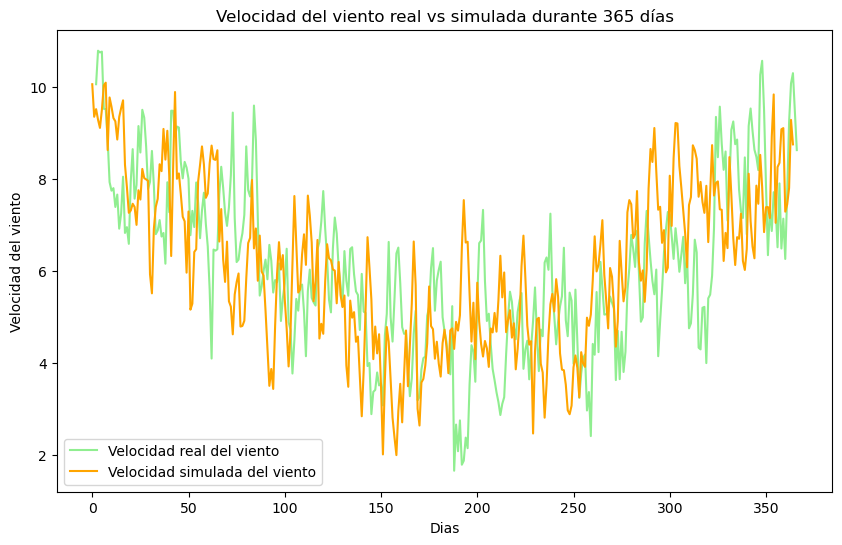

In [11]:
import matplotlib.pyplot as plt

# Graficar la velocidad del viento
plt.figure(figsize=(10, 6))
plt.plot(datos['regional wind'][:T], color='lightgreen', label='Velocidad real del viento')
plt.plot(simular_viento, color='orange', label='Velocidad simulada del viento')

# Añadir etiquetas y título
plt.xlabel('Dias')
plt.ylabel('Velocidad del viento')
plt.title('Velocidad del viento real vs simulada durante 365 días')

# Añadir leyenda
plt.legend()

# Mostrar el gráfico
plt.show()

Vemos que en el largo plazo, hay una correlacion positiva entre ambos, por lo que resulta razonable pensar que el camino simulado se parece al camino real

### Grafico comparativo de la diferencia de velocidad del viento entre el norte y el sur real vs la simulada

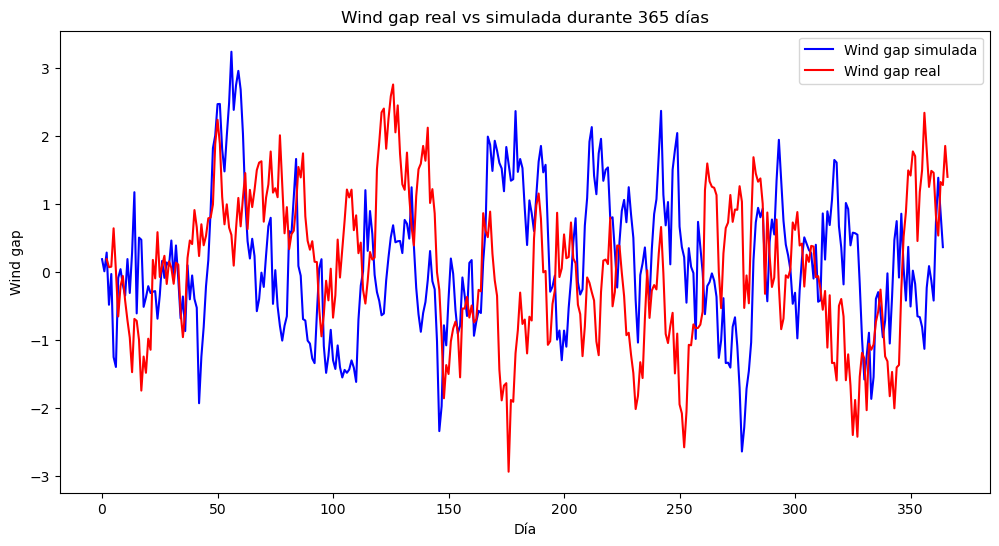

In [12]:
# Graficar las simulaciones
plt.figure(figsize=(12, 6))
plt.plot(simular_gap, color='blue', label='Wind gap simulada')
plt.plot(datos["wind gap norte sur"][:T], color='red', label='Wind gap real')

plt.xlabel('Día')
plt.ylabel('Wind gap')
plt.title('Wind gap real vs simulada durante 365 días')
plt.legend()
plt.show()


### Gráfico comparativo de la velocidad simulada del viento para los molinos norte y sur

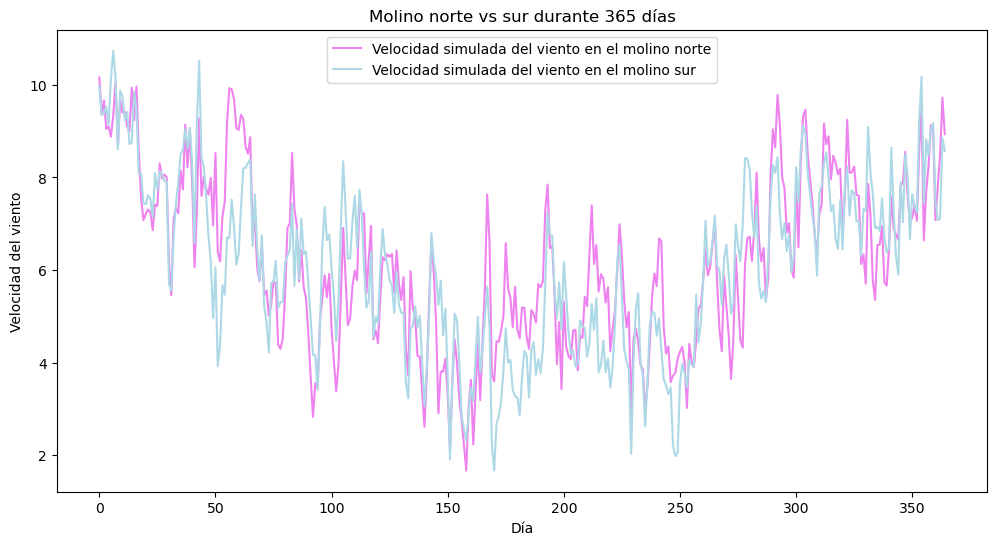

In [13]:
# Graficar las simulaciones
plt.figure(figsize=(12, 6))
plt.plot(simulacion_norte, color='violet', label='Velocidad simulada del viento en el molino norte')
plt.plot(simulacion_sur, color='lightblue', label='Velocidad simulada del viento en el molino sur')

plt.xlabel('Día')
plt.ylabel('Velocidad del viento')
plt.title('Molino norte vs sur durante 365 días')
plt.legend()
plt.show()

Si bien hay periodos dentro del corto plazo donde la correlacion no es positiva, en el largo plazo ambos caminos se expanden de la misma manera, con correlación positiva

# Ejercicio 3

In [46]:
def simular_rotura(p):
    return 1 if random.uniform(0,1) < p else 0

def calcular_VAN(T, viento, k):
    delta = 1/T
    S = viento
    activo = False
    VAN = 0
    VAN_diario = []

    estado_molino = []
    rotura = []

    for i in range(0, T):
        tasa_descuento = math.exp(-0.05 * i / 365)

        probabilidad_rotura = 0.25*(S[i]**2)*delta
        if(activo):
            esta_roto = simular_rotura(probabilidad_rotura)

            if(esta_roto):
                VAN -= 200000
                activo = False
                rotura.append(1)
            
            else:

                rotura.append(0)

                if(S[i] >= k):
                    activo = False
                    VAN -= 1000

                else:
                    VAN += 1000 * S[i]
        
        else:

            if(S[i] < k):
                activo = True
                VAN += 1000 * S[i]
        
            rotura.append(0)

        VAN = VAN * tasa_descuento

        VAN_diario.append(VAN)
        estado_molino.append(activo)
    
    return VAN_diario, estado_molino, rotura

def simular_ambos_molinos(sim_norte, sim_sur, T, k) -> List:

    VAN_molino_norte,estados_molino_norte,roturas_molino_norte = calcular_VAN(T,sim_norte,k)

    info_molino_norte = (VAN_molino_norte,estados_molino_norte,roturas_molino_norte)

    VAN_molino_sur,estados_molino_sur,roturas_molino_sur = calcular_VAN(T, sim_sur,k)

    info_molino_sur = (VAN_molino_sur,estados_molino_sur,roturas_molino_sur)

    return [info_molino_norte, info_molino_sur]

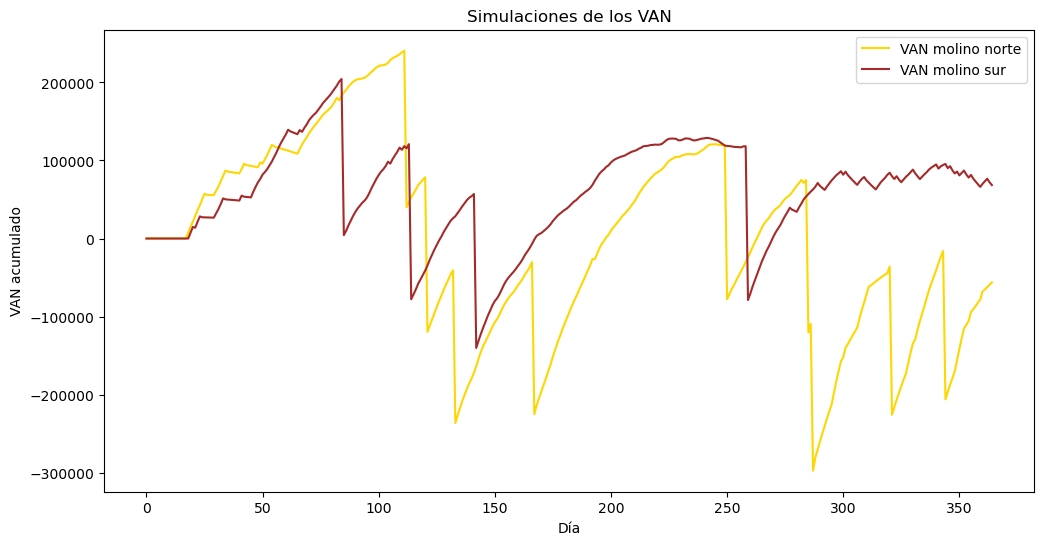

In [47]:
simulacion_ambos_molinos = simular_ambos_molinos(simulacion_norte,simulacion_sur,T,7.6)

simular_VAN_molino_norte = simulacion_ambos_molinos[0][0]

simular_VAN_molino_sur = simulacion_ambos_molinos[1][0]

# Graficar las simulaciones
plt.figure(figsize=(12, 6))
plt.plot(simular_VAN_molino_norte, color='gold', label='VAN molino norte')
plt.plot(simular_VAN_molino_sur, color='brown', label='VAN molino sur')

plt.xlabel('Día')
plt.ylabel('VAN acumulado')
plt.title('Simulaciones de los VAN')
plt.legend()
plt.show()

# Ejercicio 4

In [48]:
def graficar_estado_molino(sim,roturas,encendido,region,k):
    # Datos ya calculados: simulacion_norte (velocidad del viento), simular_encendido_norte (estado de encendido) y simular_rotura_norte (roturas)
    dias = np.arange(len(sim))

    # Graficar la velocidad del viento
    plt.figure(figsize=(10, 6))
    plt.plot(dias, sim, color='orange', label='Velocidad simulada del viento', linewidth=0.85)

    # Graficar línea verde o roja según el valor de simular_encendido_norte
    for i in range(len(sim) - 1):
        if encendido[i] == 1:  # Encendido (True)
            plt.plot([dias[i], dias[i+1]], [sim[i], sim[i+1]], color='green', linewidth=2)
        else:  # Apagado (False)
            plt.plot([dias[i], dias[i+1]], [sim[i], sim[i+1]], color='red', linewidth=2)

    # Graficar roturas con puntos en la posición donde ocurre una rotura (simular_rotura_norte == 1)
    rotura_indices = np.where(np.array(roturas) == 1)[0]
    plt.scatter(rotura_indices, np.array(sim)[rotura_indices], color='blue', label=f'Rotura molino {region}', zorder=5)

    # Graficar línea horizontal en y = 9
    plt.axhline(y=k, color='black', linestyle='--', label='Umbral de apagado')

    # Añadir etiquetas y título
    plt.xlabel('Días')
    plt.ylabel('Velocidad del viento')
    plt.title('Velocidad del viento real vs simulada con estado de encendido y roturas')

    # Añadir leyenda con colores personalizados
    legend_labels = ['Encendido (verde)', 'Apagado (rojo)', f'Rotura molino {region}', 'Umbral de apagado']
    legend_colors = ['green', 'red', 'blue', 'black']
    handles = [plt.Line2D([0], [0], color=color, lw=2) for color in legend_colors]
    plt.legend(handles, legend_labels)

    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()

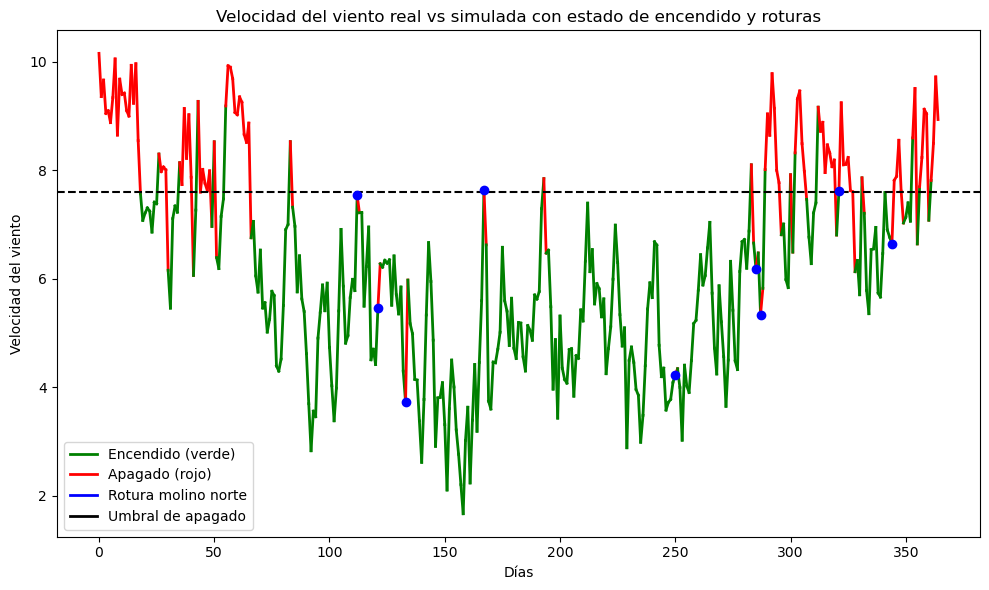

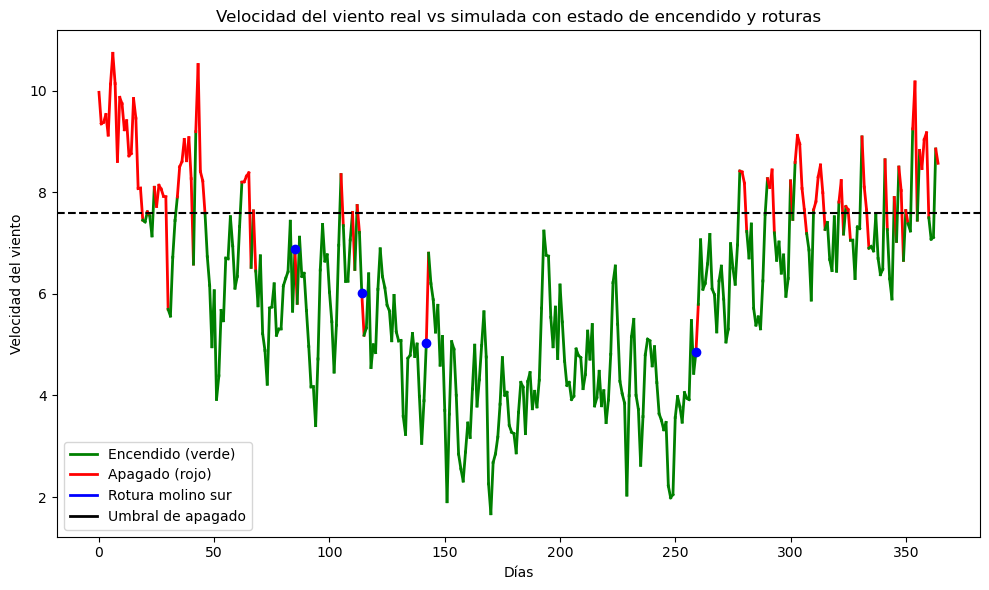

In [51]:
simular_encendido_norte = simulacion_ambos_molinos[0][1]

simular_rotura_norte = simulacion_ambos_molinos[0][2]

simular_norte = simulacion_ambos_molinos[0][0]

simular_encendido_sur = simulacion_ambos_molinos[1][1]

simular_rotura_sur = simulacion_ambos_molinos[1][2]

simular_sur = simulacion_ambos_molinos[1][0]

graficar_estado_molino(simulacion_norte,simular_rotura_norte,simular_encendido_norte,"norte",7.6)

graficar_estado_molino(simulacion_sur,simular_rotura_sur,simular_encendido_sur,"sur",7.6)


En el gráfico podemos observar como las 3 simulaciones se expanden de manera simetrica a traves del tiempo, esto nos lleva a pensar que los modelos implementados anteriormente son fieles a los datos proporcionados, mostrando una correlacion de largo plazo positiva.


A CHEQUEAR REY

# Ejercicio 5

El VAN esperado se calcula como el promedio de los VANs simulados:
$$
\text{VAN esperado} = \frac{1}{N} \sum_{j=1}^N \text{VAN}_j
$$

donde:
- N es el número total de simulaciones.
- $\text{VAN}_j$ es el VAN del j-ésimo camino simulado.


In [52]:
def VAN_esperado(k, N, T, simulaciones_generales):

    simulaciones_regionales = []

    for i in range(N):

        VAN_norte = calcular_VAN(T, simulaciones_generales[i][0], k)
        VAN_sur = calcular_VAN(T, simulaciones_generales[i][1], k)

        simulaciones_regionales.append(VAN_norte + VAN_sur)

    VAN_esperado = np.mean(simulaciones_regionales)
    res = VAN_esperado

    return(res)



El error de estimación del VAN esperado se calcula en dos pasos:

1. **Calcular la Desviación Estándar de los VANs Simulados**:

   La fórmula para la desviación estándar $\sigma_{\text{VAN}}$ es:
   $$
   \sigma_{\text{VAN}} = \sqrt{\frac{1}{N-1} \sum_{j=1}^N (\text{VAN}_j - \text{VAN esperado})^2}
   $$

   Donde:
   - N es el número total de simulaciones.
   - $\text{VAN}_j$ es el VAN del j-ésimo camino simulado.
   - $\text{VAN esperado}$ es el promedio de los VANs simulados.

2. **Calcular el Error Estándar del VAN Esperado**:

   La fórmula para el error estándar es:
   $$
   \text{Error estándar} = \frac{\sigma_{\text{VAN}}}{\sqrt{N}}
   $$

   Donde:
   - $\sigma_{\text{VAN}}$ es la desviación estándar de los VANs simulados.
   - N es el número total de simulaciones.


In [53]:
def estimar_error_muestral(datos):

    # Calcular la desviación estándar de los datos
    desviacion_estandar = np.std(datos, ddof=1)  # ddof=1 para obtener la desviación estándar muestral

    # Calcular el error estándar
    error_estandar = desviacion_estandar / np.sqrt(len(datos))

    return error_estandar


Decidimos implementar la funcion de estimar error para un conjunto de datos generico y no para el VAN esperado unicamente ya que luego la vamos a querer utilizar para estimar otros errores muestrales usando la misma formula

# Ejercicio 6

### Optimización del Umbral de Viento k para Maximizar el VAN

Queremos encontrar el valor del umbral de viento k que maximiza el Valor Actual Neto (VAN) generado por los molinos de viento en un año. Para ello, vamos utilizar simulaciones de Monte Carlo siguiendo estos pasos:

1. Definir un rango de valores de k
2. Implementar la simulación para calcular el VAN esperado para cada valor de k para N simulaciones.
3. Comparar los VANs obtenidos y seleccionar el k óptimo que maximice el VAN esperado.


In [55]:
N = 1000
umbrales = np.arange(6, 10, 0.1)
lista_VANs_total = []

simulaciones_generales = generar_simulaciones(N)

# Llenar las listas con las tuplas de [VAN, k]
for k in umbrales:

    print(k)

    VAN_esperado_dado_k = VAN_esperado(k, N, T,simulaciones_generales)
    lista_VANs_total.append((VAN_esperado_dado_k, k))

# Encontrar el valor de k más alto considerando VAN y luego k
k_optimo_general = max(lista_VANs_total, key=lambda x: (x[0], x[1]))[1]  # Max en función de [VAN, k], solo devuelve k

print(f"El valor óptimo de k es: {k_optimo_general}")


6.0
6.1
6.199999999999999
6.299999999999999
6.399999999999999
6.499999999999998
6.599999999999998
6.6999999999999975
6.799999999999997
6.899999999999997
6.9999999999999964
7.099999999999996
7.199999999999996
7.299999999999995
7.399999999999995
7.499999999999995
7.599999999999994
7.699999999999994
7.799999999999994
7.899999999999993
7.999999999999993
8.099999999999993
8.199999999999992
8.299999999999992
8.399999999999991
8.499999999999991
8.59999999999999
8.69999999999999
8.79999999999999
8.89999999999999
8.99999999999999
9.099999999999989
9.199999999999989
9.299999999999988
9.399999999999988
9.499999999999988
9.599999999999987
9.699999999999987
9.799999999999986
9.899999999999986
El valor óptimo de k es: 7.799999999999994


# Ejercicio 7

Calculamos el VAN esperado para 10000 simulaciones (Monte Carlo) para ver a donde converge en cada tipo de operacion:

- Operacion optima: utilizando k = 7.9
- Operacion ingenua: utilizando k >> 7.9 (nunca se apaga el molino)

Luego comparamos los resultados

In [58]:
k_optimo = 7.9
k_ingenuo = 10000
N_iter = 1000

sims = generar_simulaciones(N_iter)

VAN_esperado_ingenuo = VAN_esperado(k_ingenuo, N_iter, 365, sims)
VAN_esperado_optimo = VAN_esperado(k_optimo, N_iter, 365, sims)

print(VAN_esperado_ingenuo)
print(VAN_esperado_optimo)

6468.641564860204
8258.30473658676


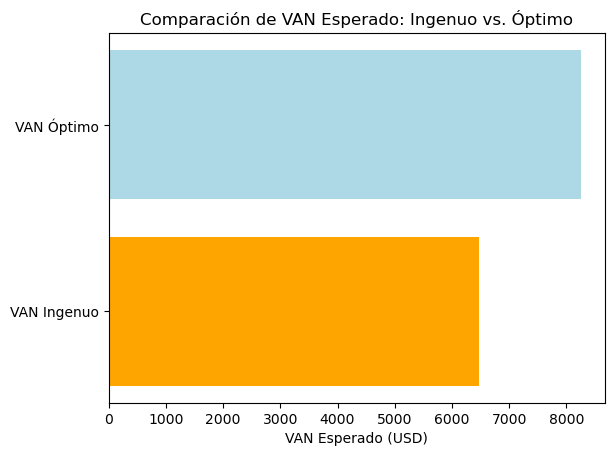

In [59]:
# Nombres de las categorías
categorias = ['VAN Ingenuo', 'VAN Óptimo']

# Colores correspondientes a cada barra
colores = ['orange', 'lightblue']

# Crear gráfico de barras horizontal
plt.barh(categorias, [VAN_esperado_ingenuo, VAN_esperado_optimo], color=colores)

# Añadir etiquetas
plt.xlabel('VAN Esperado (USD)')
plt.title('Comparación de VAN Esperado: Ingenuo vs. Óptimo')

# Mostrar gráfico
plt.show()

Podemos observar una diferencia del 28% entre las operaciones, donde hay una evidente mejora cuando se usa un k optimizado

# Ejercicio 8

Al ingreso del mes de Agosto lo podemos medir como el ingreso entre los días 213 (1 de Agosto) y 243 (31 de Agosto) de nuestro modelo.

Primero, implementamos una funcion para calcular el VAN sin comtemplar la tasa de descuento diaria

In [60]:
def calcular_VAN_sin_descuento(T, viento, k):
    delta = 1/T
    S = viento
    activo = False
    VAN = 0
    VAN_diario = []

    estado_molino = []
    rotura = []

    for i in range(0, T):
        tasa_descuento = 1
        estado_molino.append(activo)

        probabilidad_rotura = 0.25*(S[i]**2)*delta
        if(activo):
            esta_roto = simular_rotura(probabilidad_rotura)

            if(esta_roto):
                VAN -= 200000 * tasa_descuento
                activo = False
                rotura.append(1)
            
            else:

                rotura.append(0)

                if(S[i] >= k):
                    activo = False
                    VAN -= 1000 * tasa_descuento

                else:
                    VAN += 1000 * S[i] * tasa_descuento
        
        else:

            if(S[i] < k):
                activo = True
                VAN += 1000 * S[i] * tasa_descuento
        
            rotura.append(0)

        VAN_diario.append(VAN)
    
    return VAN_diario, estado_molino, rotura

A traves de Monte Carlo, calculamos los ingresos de agosto para 10000 simulaciones distintas para despues poder graficar la distribucion del mismo

In [63]:
ingresos_agosto = []

for i in range(10000):

    viento_agosto = generar_viento_regional(kappa_estimado,sigma_estimado,T)[213:244]
    gap_agosto = generar_gap_norte_sur(beta_estimado,gamma_estimado,T)[213:244]

    viento_norte_agosto = viento_agosto + gap_agosto/2
    viento_sur_agosto = viento_agosto - gap_agosto/2

    ingreso_norte_agosto = calcular_VAN_sin_descuento(len(viento_norte_agosto),viento_norte_agosto,7.9)[0][-1]
    ingreso_sur_agosto = calcular_VAN_sin_descuento(len(viento_sur_agosto),viento_sur_agosto,7.9)[0][-1]

    ingresos_agosto.append(ingreso_norte_agosto + ingreso_sur_agosto)

print(estimar_error_muestral(ingresos_agosto))

print(np.mean(ingresos_agosto))

5323.479133154181
-1550818.0289513892


Graficamos la distribucion de los ingresos de agosto a traves de un histograma de frecuencia

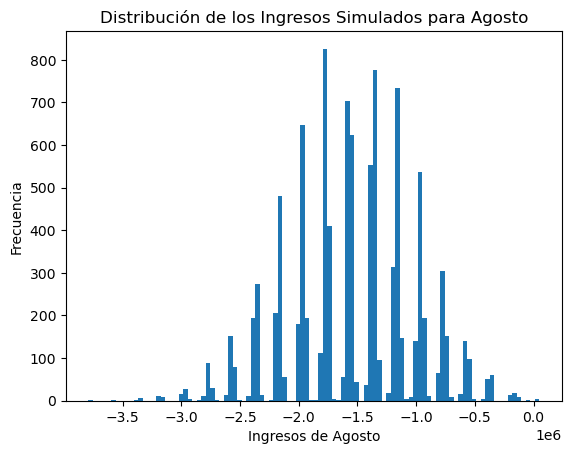

In [64]:
plt.hist(ingresos_agosto, bins = 100)
plt.xlabel('Ingresos de Agosto')
plt.ylabel('Frecuencia')
plt.title('Distribución de los Ingresos Simulados para Agosto')
plt.show()

Podemos observar que la distribucion del ingreso de agosto tiene forma de campana, lo cual es un primer indicio de que la variable es normal

# Ejercicio 9

In [70]:
roturas_agosto_k_optimo = []

roturas_agosto_k_ingenuo = []

simulaciones_9 = generar_simulaciones(10000)

for i in range(10000):
    
    s_norte = simulaciones_9[i][0]

    s_sur = simulaciones_9[i][1]

    b_k_optimo = simular_ambos_molinos(s_norte, s_sur, T, 7.9)

    b_k_ingenuo = simular_ambos_molinos(s_norte, s_sur, T, 100000)

    rotura_k_optimo = sum(b_k_optimo[0][2]) + sum(b_k_optimo[1][2])

    rotura_k_ingenuo = sum(b_k_ingenuo[0][2]) + sum(b_k_ingenuo[1][2])

    roturas_agosto_k_optimo.append(rotura_k_optimo)
    roturas_agosto_k_ingenuo.append(rotura_k_ingenuo)

print(np.mean(roturas_agosto_k_optimo)/2)

print(np.mean(roturas_agosto_k_ingenuo))


Simulaciones generadas exitosamente
6.5295
19.1637


# Ejercicio 10

In [72]:
actividad_norte = []

actividad_sur = []

simulaciones_10 = generar_simulaciones(10000)

for i in range(10000):

    s_norte = simulaciones_10[i][0]

    s_sur = simulaciones_10[i][1]

    b = simular_ambos_molinos(s_norte, s_sur, T, 7)

    estado_norte = sum(b[0][1])

    estado_sur = sum(b[1][1])

    actividad_norte.append(estado_norte)
    actividad_sur.append(estado_sur)

print(np.mean(actividad_norte))
print(np.mean(actividad_sur))

Simulaciones generadas exitosamente
244.1465
244.1074


Vemos que, en promedio, ambos molinos estan encendidos durante 244 dias del año, lo que equivale a decir que ambos suelen estar apagados aproximadamente 122 días del año. Esto quiere decir que alrededor de un tercio del año los molinos no generan ganancias

In [73]:
error_estimacion_norte = estimar_error_muestral(actividad_norte)
error_estimacion_sur = estimar_error_muestral(actividad_sur)

print(error_estimacion_norte)
print(error_estimacion_sur)

0.14697484116471615
0.14542187344456683


# Ejercicio 11

Dado que las roturas de cada molino son eventos independientes, podemos estimar la probabilidad de que ambos estén inactivos como:

$$
P(\text{inactividad el 9 de julio}) = P(N_{189} = 0) \times P(S_{189} = 0)
$$

Donde:

- $N_{189}$ es el estado del molino norte en el día 189 del año (9 de julio)
- $S_{189}$ es el estado del molino sur en el día 189 del año (9 de julio)


Por otro lado, el error de estimación de $\hat{p}$ se puede calcular como:

$$
SE = \sqrt{\frac{\hat{p} \cdot (1 - \hat{p})}{N}}
$$

donde:

- $\hat{p}$ es la estimación de la proporcion deseada
- $N$ es el número de simulaciones

In [75]:
actividad_norte_9_julio = []

actividad_sur_9_julio = []

simulaciones_11 = generar_simulaciones(10000)

for i in range(10000):

    s_norte = simulaciones_11[i][0]

    s_sur = simulaciones_11[i][1]

    b = simular_ambos_molinos(s_norte, s_sur, T, 7)

    estado_norte = b[0][1][189]

    estado_sur = b[1][1][189]

    actividad_norte_9_julio.append(estado_norte)
    actividad_sur_9_julio.append(estado_sur)

# Calcular la proporción de inactividad para cada molino
proporcion_inactividad_norte = np.sum(np.array(actividad_norte_9_julio) == 0) / len(actividad_norte_9_julio)
proporcion_inactividad_sur = np.sum(np.array(actividad_sur_9_julio) == 0) / len(actividad_sur_9_julio)

# Imprimir las proporciones de inactividad
print(f'Proporción de inactividad del molino norte el 9 de julio: {proporcion_inactividad_norte*100}%')
print(f'Proporción de inactividad del molino sur el 9 de julio: {proporcion_inactividad_sur*100}%')

# Calcular la probabilidad de que ambos molinos estén inactivos
probabilidad_inactividad_9_julio = proporcion_inactividad_norte * proporcion_inactividad_sur

print(f'Probabilidad de que ambos molinos estén inactivos el 9 de julio: {probabilidad_inactividad_9_julio*100}%')

SE = np.sqrt(probabilidad_inactividad_9_julio * (1 - probabilidad_inactividad_9_julio) / 10000)
print(f'Error estándar de la probabilidad: {SE}')

Simulaciones generadas exitosamente
Proporción de inactividad del molino norte el 9 de julio: 2.46%
Proporción de inactividad del molino sur el 9 de julio: 2.08%
Probabilidad de que ambos molinos estén inactivos el 9 de julio: 0.051168000000000005%
Error estándar de la probabilidad: 0.00022614556895451214


Podemos observar que la probabilidad de ambos molinos esten inactivos el 9 de julio es cercana a 0, lo que lo convierte en un evento bastante improbable

Para estimar la probabilidad de que ambos molinos estén inactivos en algún día del año, podemos usar Monte Carlo:

$$
P(\text{inactividad en algún día del año}) = \frac{1}{365} \sum_{i=1}^{365} \mathbb{I}(N_{i} = 0 \cap S_{i} = 0)
$$

Donde:

- $\mathbb{I}$ es la función indicadora que toma el valor 1 si ambos molinos están inactivos en el día $i$ y 0 en caso contrario.
- $N_{i}$ es el estado del molino norte en el día $i$.
- $S_{i}$ es el estado del molino sur en el día $i$.

In [77]:
cantidad_coincidencias = 0

simulaciones_11 = generar_simulaciones(10000)

for i in range(10000):

    s_norte = simulaciones_11[i][0]

    s_sur = simulaciones_11[i][1]

    b = simular_ambos_molinos(s_norte, s_sur, T, 7)

    estado_norte = b[0][1]

    estado_sur = b[1][1]

    for i in range(T):
        if(estado_norte[i] == 0 and estado_sur[i] == 0):
            cantidad_coincidencias += 1

cantidad_coincidencias = cantidad_coincidencias/10000

probabilidad_inactividad = 1/T * cantidad_coincidencias
print(f'Probabilidad de que ambos molinos estén inactivos en algun dia del año: {probabilidad_inactividad}')

SE = np.sqrt(probabilidad_inactividad * (1 - probabilidad_inactividad) / 10000)
print(f'Error estándar de la probabilidad: {SE}')

Simulaciones generadas exitosamente
Probabilidad de que ambos molinos estén inactivos en algun dia del año: 0.25043452054794524
Error estándar de la probabilidad: 0.004332632819266664


# Ejercicio 12

In [78]:
def calcular_correlacion(X, Y):
    # Calcular las medias
    media_X = np.mean(X)
    media_Y = np.mean(Y)
    
    # Calcular las desviaciones estándar
    desvio_X = np.sqrt(np.sum((X - media_X)**2))
    desvio_Y = np.sqrt(np.sum((Y - media_Y)**2))
    
    # Calcular la covarianza
    covarianza = np.sum((X - media_X) * (Y - media_Y))
    
    # Calcular la correlación
    correlacion = covarianza / (desvio_X * desvio_Y)
    
    return correlacion

In [84]:
N_simulaciones = 10000  # Define cuántas simulaciones quieres hacer
ingresos_mayo_norte = []
ingresos_mayo_sur = []

simulaciones_12 = generar_simulaciones(N_simulaciones)

for _ in range(N_simulaciones):
    
    s_norte = simulaciones_12[i][0]

    s_sur = simulaciones_12[i][1]
    
    # Calcular el VAN diario para mayo (días 121 a 151 del año)
    VAN_norte = calcular_VAN(365, s_norte, 7)[0]
    VAN_sur = calcular_VAN(365, s_sur, 7)[0]
    
    # Sumar los ingresos diarios para mayo (días 121 a 151)
    ingreso_mensual_norte = VAN_norte[151] - VAN_norte[121]
    ingreso_mensual_sur = VAN_sur[151] - VAN_sur[121]
    
    # Guardar los totales en listas
    ingresos_mayo_norte.append(ingreso_mensual_norte)
    ingresos_mayo_sur.append(ingreso_mensual_sur)


# # Ploteo de los ingresos de ambos molinos
# plt.figure(figsize=(10, 6))

# # Plotear el molino norte en azul y el sur en rojo
# plt.scatter(ingresos_mayo_norte, ingresos_mayo_sur, alpha=0.5, color='blue', label='Molino Norte')
# plt.scatter(ingresos_mayo_sur, ingresos_mayo_norte, alpha=0.5, color='red', label='Molino Sur')

# plt.title('Ingresos de Mayo: Molino Norte vs Molino Sur')
# plt.xlabel('Ingresos Mayo - Molino Norte')
# plt.ylabel('Ingresos Mayo - Molino Sur')
# plt.grid(True)

# plt.show()


Simulaciones generadas exitosamente


In [85]:
#correlacion = calcular_correlacion(np.sum(ingresos_mayo_norte), np.sum(ingresos_mayo_sur))

#correlacion = np.corrcoef(np.sum(ingresos_mayo_norte), np.sum(ingresos_mayo_sur))


print(f'Correlación del ingreso mensual de mayo entre los dos molinos: {correlacion}')

Correlación del ingreso mensual de mayo entre los dos molinos: [[nan nan]
 [nan nan]]


# Ejercicio 13

La sensibilidad se puede calcular utilizando diferencias finitas de la siguiente manera:

$$
\frac{\partial E[f(\alpha, S_T)]}{\partial \alpha} \approx \frac{E[f(\alpha + \epsilon, S_T)] - E[f(\alpha - \epsilon, S_T)]}{2\epsilon}
$$

Donde:
- $\alpha$ es el parámetro de interés.
- $\epsilon$ es un pequeño incremento.
- $E[f(\alpha, S_T)]$ es el valor esperado de la función \( f \) con el parámetro $\alpha$ y el proceso estocástico \( S_T \).

Para calcular esta sensibilidad, se realizan simulaciones para $\alpha$ + $\epsilon$ y $\alpha$ - $\epsilon$, y se utiliza la fórmula de diferencias finitas para estimar la derivada.

In [ ]:
def calcular_VAN_modificado(T, viento, k, costo_arreglo):
    delta = 1/T
    S = viento
    activo = False
    VAN = 0
    VAN_diario = []

    estado_molino = []
    rotura = []

    for i in range(0, T):
        tasa_descuento = math.exp(-0.05 * i / 365)

        probabilidad_rotura = 0.25 * (S[i]**2) * delta
        if activo:
            
            esta_roto = simular_rotura(probabilidad_rotura)

            if esta_roto:
                VAN -= costo_arreglo
                activo = False
                rotura.append(1)

            else:
                rotura.append(0)
                if S[i] >= k:
                    activo = False
                    VAN -= 1000
                else:
                    VAN += 1000 * S[i]
        else:
            if S[i] < k:
                activo = True
                VAN += 1000 * S[i] 

            rotura.append(0)

        VAN = VAN * tasa_descuento

        VAN_diario.append(VAN)
        estado_molino.append(activo)
        
    return VAN_diario, estado_molino, rotura


In [ ]:
def VAN_esperado_modificado(k, N, T, costo_arreglo,sims):
    simulaciones = sims

    simulaciones_regionales = []

    for i in range(N):
        
        camino_norte = simulaciones[i][0]
        camino_sur = simulaciones[i][1]

        VAN_norte, _, _ = calcular_VAN_modificado(T, camino_norte, k, costo_arreglo)
        VAN_sur, _, _ = calcular_VAN_modificado(T, camino_sur, k, costo_arreglo)

        simulaciones_regionales.append(VAN_norte[-1] + VAN_sur[-1])

    VAN_esperado = np.mean(simulaciones_regionales)
    return VAN_esperado

In [ ]:
def calcular_sensibilidad(costo_arreglo_actual, costo_arreglo_nuevo, N, T, k):

    sims = generar_simulaciones(N)

    # Calcular VAN esperado para el costo de arreglo actual
    VAN_esperado_actual = VAN_esperado_modificado(k, N, T, costo_arreglo_actual,sims)
    
    # Calcular VAN esperado para el nuevo costo de arreglo
    VAN_esperado_nuevo = VAN_esperado_modificado(k, N, T, costo_arreglo_nuevo,sims)
    
    # Calcular la sensibilidad utilizando la fórmula de diferencias finitas
    sensibilidad = (VAN_esperado_nuevo - VAN_esperado_actual) / (costo_arreglo_nuevo - costo_arreglo_actual)
    
    return sensibilidad

costo_arreglo_actual = 200000  # Costo viejo
costo_arreglo_nuevo = 250000   # Nuevo costo

N = 10000
T = 365 
k = 7.9

sensibilidad = calcular_sensibilidad(costo_arreglo_actual, costo_arreglo_nuevo, N, T, k)

print(f"La sensibilidad calculada es: {sensibilidad}")

In [ ]:
# Parámetros de entrada
N = 100000
T = 365  # Horizonte temporal (días)
umbrales = np.arange(5, 12)

# Gráfico del cambio del VAN y el umbral óptimo para costos entre 200 y 250 mil dólares
costos_arreglo = np.linspace(200000, 250000, 9)
VANs_esperados = []
umbrales_optimos = []

simulaciones_regionales = generar_simulaciones(N)


In [ ]:
costos_arreglo = np.linspace(0, 500000, 19)

for costo in costos_arreglo:

    print(f"costo: {costo}")

    lista_VANs_total = []

    VAN_esperado_dado_k = VAN_esperado_modificado(7.9, 1000, T, costo, simulaciones_regionales)

    lista_VANs_total.append((VAN_esperado_dado_k, k))
    
    #k_optimo_general = max(lista_VANs_total, key=lambda x: (x[0], x[1]))[1]
    
    #umbrales_optimos.append(k_optimo_general)
    VANs_esperados.append(max(lista_VANs_total)[0])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(costos_arreglo, VANs_esperados)
plt.xlabel('Costo del Arreglo')
plt.ylabel('VAN Esperado')
plt.title('Cambio del VAN Esperado con el Costo del Arreglo')

# plt.subplot(1, 2, 2)
# plt.plot(costos_arreglo, umbrales_optimos)
# plt.xlabel('Costo del Arreglo')
# plt.ylabel('Umbral Óptimo (k)')
# plt.title('Cambio del Umbral Óptimo con el Costo del Arreglo')

plt.tight_layout()
plt.show()

In [ ]:
N_2 = 100

umbrales = np.arange(5, 12,0.5)
lista_VANs_norte = []
lista_VANs_sur = []
lista_VANs_total = []

# Llenar las listas con las tuplas de [VAN, k]
for k in umbrales:

    a = generar_simulaciones(N_2)

    VAN_esperado_dado_k = VAN_esperado_modificado(k,N_2,T,250000,a)

    lista_VANs_total.append((VAN_esperado_dado_k,k))

# Encontrar el valor de k más alto considerando VAN y luego k
k_optimo_general = max(lista_VANs_total, key=lambda x: (x[0], x[1]))[1]  # Max en función de [VAN, k]

print(f"El valor óptimo de k es: {k_optimo_general}")


Como se observa en el gráfico, un aumento en el costo de reparación de $200,000 a $250,000 resulta en una disminución significativa del VAN esperado. Esto indica que cualquier incremento en los costos de reparación tiene un impacto negativo considerable en la rentabilidad del negocio. 

Dado que el costo de reparación es ahora más alto, el umbral óptimo para la reparación debería disminuir. Esto significa que deberíamos considerar reparar el molino antes de que se produzcan daños más graves y costosos. Al reducir el umbral, minimizamos el riesgo de enfrentarnos a reparaciones extremadamente costosas.

# Ejercicio 14

Graficamos la media estacional a lo largo del año y el VAN esperado para 100000 simulaciones. Con el fin de mejorar la visualización, dividimos el VAN por un número grande para apreciar de manera mas clara cómo varía en el mismo gráfico que la media estacional.

In [ ]:
x = 10000 #cantidad de simulaciones
van_total = [0] * T 
for _ in range(x):
    simular_viento = generar_viento_regional(kappa_estimado,sigma_estimado,T)
    simular_gap = generar_gap_norte_sur(beta_estimado,gamma_estimado,T)

    simulacion_norte = simular_viento + simular_gap/2
    simulacion_sur = simular_viento - simular_gap/2
    
    simulacion_ambos_molinos = simular_ambos_molinos(simulacion_norte,simulacion_sur,T,7)

    simular_VAN_molino_norte = simulacion_ambos_molinos[0][0]

    simular_VAN_molino_sur = simulacion_ambos_molinos[1][0]

    van_total = [van_total[i] + (simular_VAN_molino_norte[i] + simular_VAN_molino_sur[i])/2 for i in range(T)]  # Suma los VAN diarios

# Calcula el promedio dividiendo cada elemento de van_total por el número de simulaciones (x)
van_acumulado = [total / x for total in van_total]

van_acumulado = [x / 100000 for x in van_acumulado] #divido para que se aprecie en el grafico (por tema escalas)

media_viento= [] #valor de la media en dia i 
for i in range(T):
    media_viento.append(theta_function(i))
dias = range(1, T+1)  # Días (eje x)

plt.figure(figsize=(10, 6))

# Graficar el VAN acumulado
plt.plot(dias, van_acumulado, label="VAN esperado", color="b")

# Graficar la media del viento
plt.plot(dias, media_viento, label="Media Estacional del Viento", color="g")

# Añadir etiquetas y leyenda
plt.xlabel("Días")
plt.ylabel("Valor")
plt.title("VAN Acumulado y Media Estacional del Viento por Día")
plt.legend()

# Mostrar el gráfico
plt.grid(True)
plt.show()

Se puede observar una clara tendencia al alza en el VAN acumulado cuando la media estacional es baja. Esto tiene sentido, ya que al disminuir la velocidad del viento, los molinos sufren menos roturas y es menos frecuente que se apaguen preventivamente. Esto resulta en un aumento evidente del VAN.